In [9]:
# =============================
# Step 1: Imports and Setup
# =============================
%pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from joblib import dump, load


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Load extracted features and labels
features = np.load('../feature_extraction_smooth/image_features.npy')  # shape: (num_samples, 500)
labels = np.load('../feature_extraction_smooth/image_labels.npy')      # shape: (num_samples,)

# Number of unique classes
num_classes = len(np.unique(labels))

# Normalize features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# One-hot encode labels
labels_categorical = to_categorical(labels, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    features_scaled, labels_categorical, test_size=0.2,
    stratify=labels, random_state=42
)

# Convert categorical labels back to integers for mapping
y_train = np.argmax(y_train_cat, axis=1)
y_test = np.argmax(y_test_cat, axis=1)


In [11]:
# Train GMM to cluster data
gmm = GaussianMixture(n_components=num_classes, random_state=42, max_iter=100, verbose=2)
gmm.fit(X_train)

print(f"GMM Converged: {gmm.converged_}")


Initialization 0
Initialization converged. time lapse 1.75958s	 lower bound 2415.09530.
GMM Converged: True


In [12]:
# Get GMM cluster labels
gmm_labels_train = gmm.predict(X_train)
gmm_labels_test = gmm.predict(X_test)


In [13]:
# Create mapping from GMM cluster to actual labels
label_mapping = {}
for cluster in np.unique(gmm_labels_train):
    indices = np.where(gmm_labels_train == cluster)[0]
    original_labels = y_train[indices]
    most_common_label = np.bincount(original_labels).argmax()
    label_mapping[cluster] = most_common_label


Evaluating KNN: 100%|██████████| 30/30 [00:00<00:00, 33.42k-value/s]


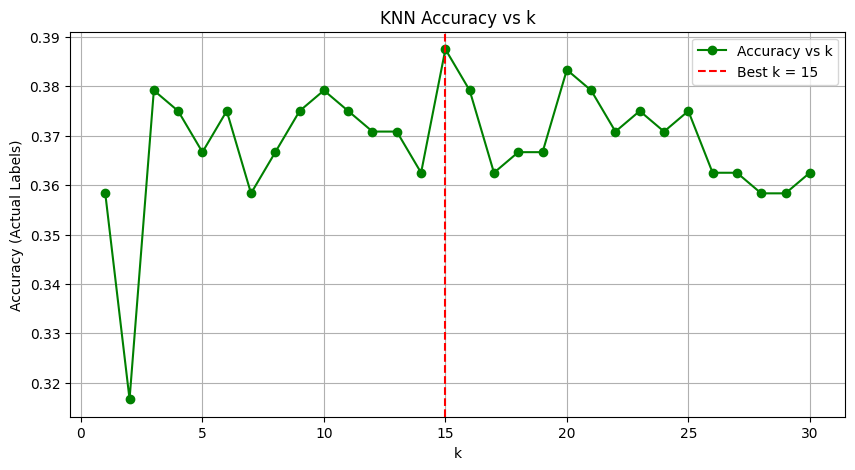

Best k: 15, Best Accuracy: 0.39


In [14]:
# Tune k from 1 to 30 using accuracy w.r.t. actual labels
k_values = range(1, 31)
accuracies_real = []

with tqdm(total=len(k_values), desc="Evaluating KNN", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, gmm_labels_train)
        gmm_pred_test = knn.predict(X_test)

        # Convert GMM predictions to actual label predictions
        predicted_labels = np.array([label_mapping[label] for label in gmm_pred_test])
        acc = accuracy_score(y_test, predicted_labels)
        accuracies_real.append(acc)
        pbar.update(1)

# Best k
best_k = k_values[np.argmax(accuracies_real)]
best_accuracy = max(accuracies_real)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies_real, marker='o', color='g', label="Accuracy vs k")
plt.axvline(best_k, linestyle='--', color='r', label=f"Best k = {best_k}")
plt.xlabel("k")
plt.ylabel("Accuracy (Actual Labels)")
plt.title("KNN Accuracy vs k")
plt.legend()
plt.grid()
plt.show()

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy:.2f}")


In [15]:
# Final model training
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, gmm_labels_train)

# Predictions
gmm_train_pred = knn.predict(X_train)
gmm_test_pred = knn.predict(X_test)

# Convert to actual labels
predicted_train_labels = np.array([label_mapping[label] for label in gmm_train_pred])
predicted_test_labels = np.array([label_mapping[label] for label in gmm_test_pred])

# Accuracy w.r.t. actual labels
train_accuracy = accuracy_score(y_train, predicted_train_labels)
test_accuracy = accuracy_score(y_test, predicted_test_labels)

print(f"Train Accuracy (actual labels): {train_accuracy:.2f}")
print(f"Test Accuracy (actual labels): {test_accuracy:.2f}")


Train Accuracy (actual labels): 0.40
Test Accuracy (actual labels): 0.39


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.13      0.12      0.13        16
           1       0.44      0.25      0.32        16
           2       0.45      0.31      0.37        16
           3       0.79      0.69      0.73        16
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        16
           6       0.40      0.12      0.19        16
           7       0.30      0.50      0.37        16
           8       0.79      0.69      0.73        16
           9       0.27      0.38      0.32        16
          10       0.62      0.81      0.70        16
          11       0.46      0.38      0.41        16
          12       0.00      0.00      0.00        16
          13       0.35      0.56      0.43        16
          14       0.27      1.00      0.42        16

    accuracy                           0.39       240
   macro avg       0.35      0.39      0.34       

c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

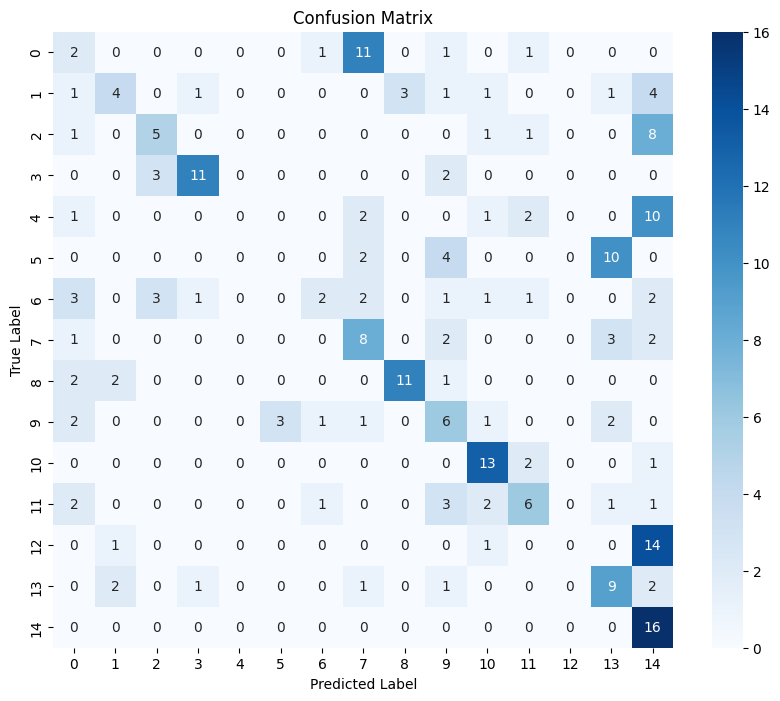

In [16]:
# Classification report
print("Classification Report (Test):")
print(classification_report(y_test, predicted_test_labels, target_names=[str(i) for i in range(num_classes)]))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_test_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)],
            yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Save the model
dump(knn, "knn_model_smooth.joblib")

# Load the model
loaded_knn = load("knn_model_smooth.joblib")
loaded_pred = loaded_knn.predict(X_test)
loaded_pred_labels = np.array([label_mapping[label] for label in loaded_pred])
loaded_accuracy = accuracy_score(y_test, loaded_pred_labels)

print(f"Loaded Model Accuracy (Test): {loaded_accuracy:.2f}")


Loaded Model Accuracy (Test): 0.39
